In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator
import random

# === Problem Setup ===
n = 100
m = 5
K = 5

# 其他参数保持不变
L_levels = [20, 18, 12, 7, 3]
E_levels = [10, 30, 40, 45, 120]
f_v_levels = [20, 30, 40, 60, 80]

E_PU_max = [9000] * m
CPU_capacity = [2000] * m
C_total_max = 12000  # 扩大到10倍
P_idle = [18] * m
P_max = [30] * m
T_total = 400

num_chains = 10  # 扩大到10倍
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [200] * num_chains

alpha_1 = 2500
alpha_2 = 10
alpha_pu = 1


params = (
    alpha_1, alpha_2, alpha_pu,
    E_levels, L_levels, f_v_levels, CPU_capacity,
    C_total_max, P_idle, P_max, T_total,
    chain_tasks, L_max, E_PU_max, n, m
)



In [2]:
#### Gurobi ####
def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 400
    model.Params.MIPGap = 0.05
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, chain_enabled=None):
    model = Model("MAF_Model")
    configure_model(model)

    # === 构建 task 到 chain 的映射 ===
    task_to_chains = {i: [] for i in range(n)}
    for k, task_list in chain_tasks.items():
        for i in task_list:
            task_to_chains[i].append(k)

    # === Definition of variables ===
    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")
    L_iK = model.addVars(n, vtype=GRB.CONTINUOUS, name="L_iK")

    # === 任务链约束 ===
    for k in range(num_chains):
        chain = chain_tasks[k]

        # 禁用某些链
        if chain_enabled is not None and chain_enabled.get(k, 1) == 0:
            model.addConstr(z_chain_k[k] == 0, name=f"Disabled_Chain_{k}")
            continue

        # 链被激活必须所有任务被接受
        model.addConstr(quicksum(delta[i] for i in chain) >= z_chain_k[k] * len(chain), name=f"Chain_{k}_Activation")

        # 链未被激活，任务也不能被接受（隐含在 delta <= sum(z_chain_k) 中）

        # End-to-End Latency 约束
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) * delta[i] for i in chain)
        communication_delay = len(chain) - 1
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # === Chain 控制 Task 激活：只有链激活才允许任务激活 ===
    for i in range(n):
        if task_to_chains[i]:
            model.addConstr(delta[i] <= quicksum(z_chain_k[k] for k in task_to_chains[i]),
                            name=f"delta_chain_dependency_{i}")

    # === Task 能耗等级与部署一致性约束 ===
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i], name=f"TaskAllocation_{i}")
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i], name=f"TaskEnergyLevel_{i}")
        model.addConstr(L_iK[i] == quicksum(y[i, k] * L_levels[k] for k in range(K)), name=f"L_iK_Calc_{i}")

        # 显式限制未激活任务的能耗等级选择为 0
        for e in range(K):
            model.addConstr(y[i, e] <= delta[i], name=f"TaskEnergyLevelZero_{i}_{e}")
        for j in range(m):
            model.addConstr(w[i, j] <= delta[i], name=f"TaskPUAssignmentZero_{i}_{j}")


    # === PU Calculation time & resource limits ===
    for j in range(m):
        execution_time = quicksum(w[i, j] * L_iK[i] for i in range(n))
        model.addConstr(U_j[j] == execution_time / T_total)
        idle_time = T_total - execution_time  

        # Calculate PU energy consumption
        model.addConstr(E_PU[j] == P_idle[j] * idle_time + (P_max[j] - P_idle[j]) * U_j[j] * T_total)

        # PU Maximum energy consumption limit
        model.addConstr(E_PU[j] <= E_PU_max[j], name=f"PU_{j}_EnergyLimit")

        # Load balancing of tasks
        #model.addConstr(quicksum(w[i, j] for i in range(n)) <= n / m + 5, name=f"PU_{j}_LoadBalance")

    # === PU 资源限制 ===
    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j],
            name=f"PU_{j}_CPU_Limit"
        )

    # === 系统整体资源限制 ===
    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max,
        name="SystemTotalResourceLimit"
    )


    # === Baseline ===
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    # === objective function ===
    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))  
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    num_tasks_selected = sum(delta[i].X for i in range(n))
    print(f"✅ 被接受的任务数: {num_tasks_selected} / {n}")

    return model 


def print_chain_status(model):
    print("\n🔍 每条链激活状态与任务 delta 值：")
    for k in range(num_chains):
        z_val = model.getVarByName(f"z_chain_k[{k}]").X
        print(f"\nChain {k} -> z_chain_k = {z_val}")
        for i in chain_tasks[k]:
            delta_val = model.getVarByName(f"delta[{i}]").X
            print(f"  Task {i}: delta = {delta_val}")


# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

def calculate_total_energy(model):
    if model is None:
        return 0, 0

    maf_energy = sum(
        model.getVarByName(f"y[{i},{e}]").X * E_levels[e]
        for i in range(n) for e in range(K)
    )

    pu_energy = sum(
        model.getVarByName(f"E_PU[{j}]").X
        for j in range(m)
    )

    return maf_energy + pu_energy

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments

In [3]:
### Greedy ####

def run_heuristic_model_with_constraints(chain_enabled=None):
    delta = [0] * n
    y = [-1] * n
    w = [-1] * n

    pu_remaining_cpu = CPU_capacity[:]
    pu_workload = [0] * m
    total_cpu_used = 0
    accepted_chains = 0

    for k in range(num_chains):
        if chain_enabled and chain_enabled.get(k, 1) == 0:
            continue

        task_list = chain_tasks[k]
        chain_latency = 0
        chain_cpu = 0
        task_energy_levels = []
        task_cpu_usage = []

        for i in task_list:
            for level in range(K):
                latency = L_levels[level]
                cpu = f_v_levels[level]
                if latency + (len(task_list)-1) <= L_max[k]:
                    task_energy_levels.append(level)
                    task_cpu_usage.append(cpu)
                    chain_latency += latency
                    chain_cpu += cpu
                    break
            else:
                break
        else:
            if total_cpu_used + chain_cpu > C_total_max:
                continue

            for j in range(m):
                if pu_remaining_cpu[j] >= chain_cpu:
                    for idx, i in enumerate(task_list):
                        delta[i] = 1
                        y[i] = task_energy_levels[idx]
                        w[i] = j
                        pu_remaining_cpu[j] -= task_cpu_usage[idx]
                        pu_workload[j] += L_levels[task_energy_levels[idx]]
                        total_cpu_used += task_cpu_usage[idx]
                    accepted_chains += 1
                    break

    maf_energy = sum(E_levels[y[i]] for i in range(n) if y[i] != -1)
    pu_energy = sum(P_idle[j] * (T_total - pu_workload[j]) + (P_max[j] - P_idle[j]) * pu_workload[j] for j in range(m))

    total_energy = maf_energy + pu_energy
    acceptance_rate = accepted_chains / num_chains

    # 在函数内直接计算objective
    objective = (
        2500 * sum(delta)
        - 10 * maf_energy
        - 1 * pu_energy
    )

    return {
        "delta": delta,
        "w": w,
        "y": y,
        "objective": objective,
        "total_energy": total_energy,
        "acceptance_rate": acceptance_rate,
        "accepted_chains": accepted_chains,
        "maf_energy": maf_energy,
        "pu_energy": pu_energy
    }


In [4]:
#### Genetic Algorithm ####
# 初始化种群
def initialize_population(pop_size, n, m, K):
    population = []
    for _ in range(pop_size):
        individual = {
            "task_pu": [random.randint(0, m - 1) for _ in range(n)],
            "task_level": [random.randint(0, K - 1) for _ in range(n)]
        }
        population.append(individual)
    return population

# 适应度计算
def calculate_fitness(individual, params):
    fitness = 0

    alpha_1, alpha_2, alpha_pu, E_levels, L_levels, f_v_levels, CPU_capacity, \
    C_total_max, P_idle, P_max, T_total, chain_tasks, L_max, E_PU_max, n, m = params

    active_tasks = len([pu for pu in individual["task_pu"] if pu >= 0])
    fitness += alpha_1 * active_tasks

    task_energy = sum(E_levels[level] for level in individual["task_level"])
    fitness -= alpha_2 * task_energy

    pu_energy = 0
    penalty = 0

    total_cpu_usage = sum(f_v_levels[individual["task_level"][i]] for i in range(n))
    if total_cpu_usage > C_total_max:
        penalty += (total_cpu_usage - C_total_max) * 1000

    for j in range(m):
        tasks_on_pu = [i for i, pu in enumerate(individual["task_pu"]) if pu == j]
        execution_time = sum(L_levels[individual["task_level"][i]] for i in tasks_on_pu)
        idle_time = max(0, T_total - execution_time)
        pu_e = P_idle[j] * idle_time + (P_max[j] - P_idle[j]) * execution_time
        pu_energy += pu_e

        cpu_usage = sum(f_v_levels[individual["task_level"][i]] for i in tasks_on_pu)
        if cpu_usage > CPU_capacity[j]:
            penalty += (cpu_usage - CPU_capacity[j]) * 1000

        if pu_e > E_PU_max[j]:
            penalty += (pu_e - E_PU_max[j]) * 1000

    fitness -= alpha_pu * pu_energy

    for chain_id, tasks in chain_tasks.items():
        chain_delay = sum(L_levels[individual["task_level"][i]] for i in tasks) + (len(tasks) - 1)
        if chain_delay > L_max[chain_id]:
            penalty += (chain_delay - L_max[chain_id]) * 1000

    fitness -= penalty

    return fitness

# 选择（轮盘赌选择）
def select_parents(population, fitnesses):
    min_fit = min(fitnesses)
    adjusted_fitnesses = [f - min_fit + 1 for f in fitnesses]
    parents = random.choices(population, weights=adjusted_fitnesses, k=2)
    return parents

# 交叉
def crossover(parent1, parent2):
    crossover_point = random.randint(0, len(parent1["task_pu"]) - 1)
    child = {
        "task_pu": parent1["task_pu"][:crossover_point] + parent2["task_pu"][crossover_point:],
        "task_level": parent1["task_level"][:crossover_point] + parent2["task_level"][crossover_point:]
    }
    return child

# 变异
def mutate(individual, m, K, mutation_rate=0.01):
    for i in range(len(individual["task_pu"])):
        if random.random() < mutation_rate:
            individual["task_pu"][i] = random.randint(0, m - 1)
        if random.random() < mutation_rate:
            individual["task_level"][i] = random.randint(0, K - 1)

def genetic_algorithm(n, m, K, generations, pop_size, mutation_rate, params):
    population = initialize_population(pop_size, n, m, K)
    best_fitness = float('-inf')
    best_individual = None

    for gen in range(generations):
        fitnesses = [calculate_fitness(ind, params) for ind in population]
        new_population = []

        max_fit = max(fitnesses)
        if max_fit > best_fitness:
            best_fitness = max_fit
            best_individual = population[fitnesses.index(max_fit)]

        while len(new_population) < pop_size:
            parents = select_parents(population, fitnesses)
            child = crossover(parents[0], parents[1])
            mutate(child, m, K, mutation_rate)
            new_population.append(child)

        population = new_population
        print(f"Generation {gen + 1}: Best Fitness = {best_fitness:.2f}")

    # 最终的个体进行计算各项指标
    alpha_1, alpha_2, alpha_pu, E_levels, L_levels, f_v_levels, CPU_capacity, \
    C_total_max, P_idle, P_max, T_total, chain_tasks, L_max, E_PU_max, n, m = params

    individual = best_individual
    delta = [1 if individual["task_pu"][i] >= 0 else 0 for i in range(n)]
    maf_energy = sum(E_levels[individual["task_level"][i]] for i in range(n))

    pu_workload = [0] * m
    for i in range(n):
        pu = individual["task_pu"][i]
        level = individual["task_level"][i]
        pu_workload[pu] += L_levels[level]

    pu_energy = sum(
        P_idle[j] * (T_total - pu_workload[j]) + (P_max[j] - P_idle[j]) * pu_workload[j] 
        for j in range(m)
    )

    total_energy = maf_energy + pu_energy

    # acceptance rate计算（满足时延限制的链数量比例）
    accepted_chains = 0
    for chain_id, tasks in chain_tasks.items():
        chain_delay = sum(L_levels[individual["task_level"][i]] for i in tasks) + (len(tasks) - 1)
        if chain_delay <= L_max[chain_id]:
            accepted_chains += 1
    acceptance_rate = accepted_chains / len(chain_tasks)

    # 明确计算Objective
    objective = (
        alpha_1 * sum(delta)
        - alpha_2 * maf_energy
        - alpha_pu * pu_energy
    )

    return {
        "delta": delta,
        "task_pu": individual["task_pu"],
        "task_level": individual["task_level"],
        "objective": objective,
        "total_energy": total_energy,
        "maf_energy": maf_energy,
        "pu_energy": pu_energy,
        "acceptance_rate": acceptance_rate,
        "accepted_chains": accepted_chains
    }



In [5]:
### run gurobi

start_time = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1, alpha_2, alpha_pu, baseline=False)
optimal_time = time.perf_counter() - start_time

start_time = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1, alpha_2, alpha_pu, baseline=True)
baseline_time = time.perf_counter() - start_time

optimal_obj = optimal_model.objVal
baseline_obj = baseline_model.objVal


Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16
✅ 被接受的任务数: 100.0 / 100
✅ 被接受的任务数: 100.0 / 100


In [6]:
# Greedy 实验
start_time = time.perf_counter()
greedy_result = run_heuristic_model_with_constraints()
greedy_time = time.perf_counter() - start_time



In [7]:
# Run GA
start = time.perf_counter()
ga_result = genetic_algorithm(n, m, K, generations=50, pop_size=30, mutation_rate=0.02, params=params)
ga_time = time.perf_counter() - start

ga_obj = ga_result["objective"]

print(f"GA Objective: {ga_obj}, Execution Time: {ga_time:.4f}s")


Generation 1: Best Fitness = 179488.00
Generation 2: Best Fitness = 180254.00
Generation 3: Best Fitness = 180730.00
Generation 4: Best Fitness = 181934.00
Generation 5: Best Fitness = 181934.00
Generation 6: Best Fitness = 182490.00
Generation 7: Best Fitness = 183092.00
Generation 8: Best Fitness = 186282.00
Generation 9: Best Fitness = 186304.00
Generation 10: Best Fitness = 186304.00
Generation 11: Best Fitness = 186304.00
Generation 12: Best Fitness = 186492.00
Generation 13: Best Fitness = 187142.00
Generation 14: Best Fitness = 188054.00
Generation 15: Best Fitness = 189174.00
Generation 16: Best Fitness = 190476.00
Generation 17: Best Fitness = 190476.00
Generation 18: Best Fitness = 190476.00
Generation 19: Best Fitness = 190476.00
Generation 20: Best Fitness = 190476.00
Generation 21: Best Fitness = 190476.00
Generation 22: Best Fitness = 191032.00
Generation 23: Best Fitness = 191802.00
Generation 24: Best Fitness = 192156.00
Generation 25: Best Fitness = 192694.00
Generatio

In [8]:
def calculate_chain_acceptance(individual, chain_tasks, L_levels, L_max):
    accepted = 0
    for chain_id, tasks in chain_tasks.items():
        chain_delay = sum(L_levels[individual["task_level"][i]] for i in tasks) + len(tasks)-1
        if chain_delay <= L_max[chain_id]:
            accepted += 1
    return accepted / len(chain_tasks)

def calculate_pu_energy(individual, params):
    _, _, _, _, L_levels, _, _, _, P_idle, P_max, T_total, _, _, _, n, m = params
    pu_energy = 0
    for j in range(m):
        tasks_on_pu = [i for i, pu in enumerate(individual["task_pu"]) if pu == j]
        execution_time = sum(L_levels[individual["task_level"][i]] for i in tasks_on_pu)
        idle_time = max(0, T_total - execution_time)
        pu_energy += P_idle[j]*idle_time + (P_max[j]-P_idle[j])*execution_time
    return pu_energy



In [9]:
# Optimal (Gurobi)
optimal_acceptance_rate = calculate_acceptance_rate(optimal_model)
optimal_energy = calculate_total_energy(optimal_model)

# Baseline (Gurobi)
baseline_acceptance_rate = calculate_acceptance_rate(baseline_model)
baseline_energy = calculate_total_energy(baseline_model)

# Greedy
greedy_acceptance_rate = greedy_result["acceptance_rate"]
greedy_energy = greedy_result["total_energy"]

# GA
ga_acceptance_rate = ga_result["acceptance_rate"]
ga_energy = ga_result["total_energy"]



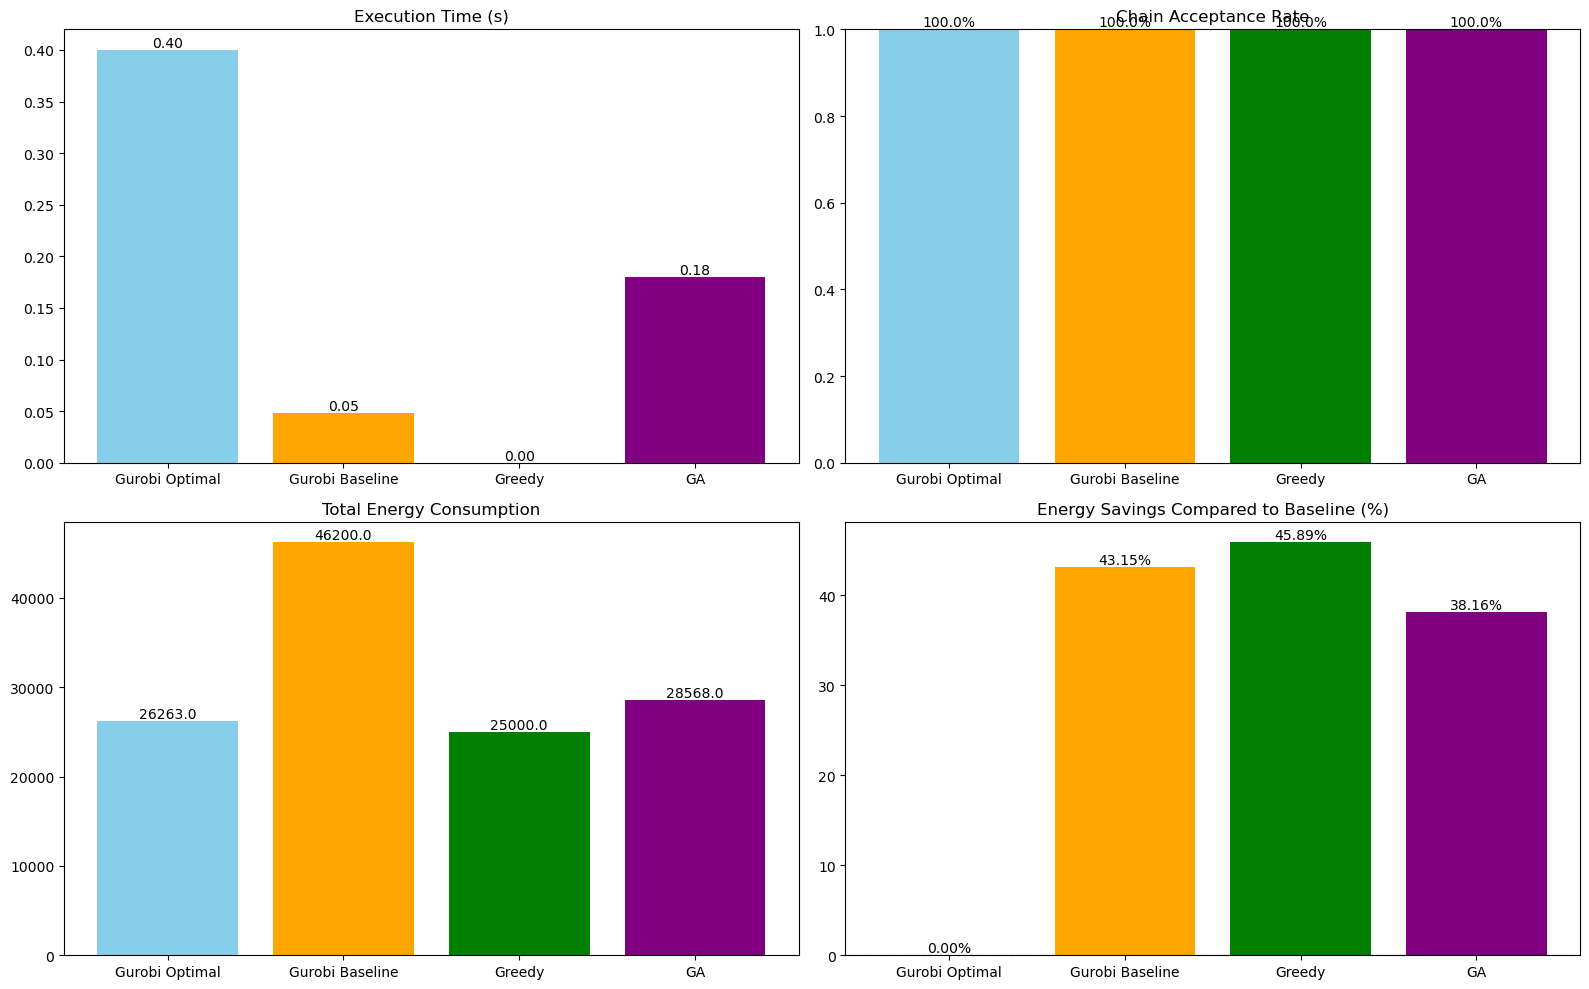

In [10]:
# 已获取的数据（示例）
labels = ["Gurobi Optimal", "Gurobi Baseline", "Greedy", "GA"]
times = [optimal_time, baseline_time, greedy_time, ga_time]
acceptance = [optimal_acceptance_rate, baseline_acceptance_rate, greedy_acceptance_rate, ga_acceptance_rate]
total_energy = [optimal_energy, baseline_energy, greedy_energy, ga_energy]

# 节能百分比计算（与Baseline对比）
saving_values = [
    0,
    (baseline_energy - optimal_energy) / baseline_energy * 100,
    (baseline_energy - greedy_energy) / baseline_energy * 100,
    (baseline_energy - ga_energy) / baseline_energy * 100
]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# === 1. 执行时间 ===
axs[0, 0].bar(labels, times, color=["skyblue", "orange", "green", "purple"])
axs[0, 0].set_title("Execution Time (s)")
for i, v in enumerate(times):
    axs[0, 0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

# === 2. 链接受比例 ===
axs[0, 1].bar(labels, acceptance, color=["skyblue", "orange", "green", "purple"])
axs[0, 1].set_title("Chain Acceptance Rate")
axs[0, 1].set_ylim(0, 1)
for i, v in enumerate(acceptance):
    axs[0, 1].text(i, v, f"{v:.1%}", ha='center', va='bottom')

# === 3. 总能耗 ===
axs[1, 0].bar(labels, total_energy, color=["skyblue", "orange", "green", "purple"])
axs[1, 0].set_title("Total Energy Consumption")
for i, v in enumerate(total_energy):
    axs[1, 0].text(i, v, f"{v:.1f}", ha='center', va='bottom')

# === 4. 节能百分比对比Baseline ===
axs[1, 1].bar(labels, saving_values, color=["skyblue", "orange", "green", "purple"])
axs[1, 1].set_title("Energy Savings Compared to Baseline (%)")
axs[1, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
for i, v in enumerate(saving_values):
    axs[1, 1].text(i, v, f"{v:.2f}%", ha='center', va='bottom')

fig.tight_layout()
plt.show()



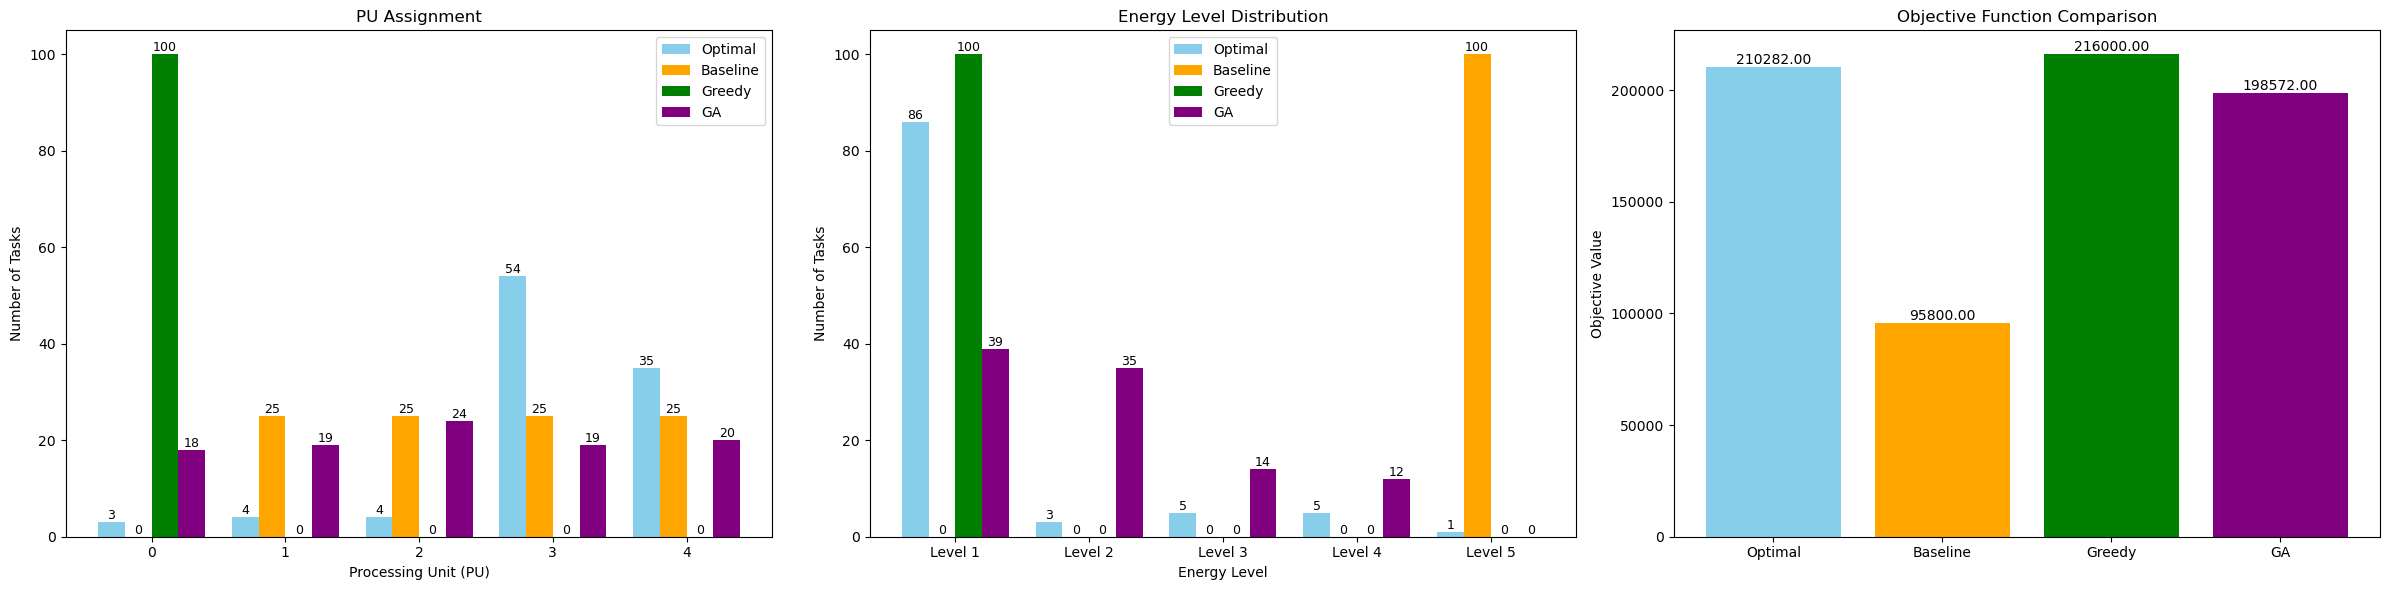

In [11]:
# PU Assignment 和 Energy Level 提取
optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

greedy_pu_assignments = greedy_result["w"]
greedy_energy_levels = greedy_result["y"]

ga_pu_assignments = ga_result["task_pu"]
ga_energy_levels = ga_result["task_level"]

# Objective Values 提取
optimal_obj = optimal_model.ObjVal
baseline_obj = baseline_model.ObjVal
greedy_obj = greedy_result["objective"]
ga_obj = ga_result["objective"]

# Plot PU Assignment, Energy Level 和 Objective Function
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# === PU Assignment ===
x = np.arange(m)
width = 0.2
axs[0].bar(x - 1.5*width, np.bincount(optimal_pu_assignments, minlength=m+1)[1:], width, label='Optimal', color='skyblue')
axs[0].bar(x - 0.5*width, np.bincount(baseline_pu_assignments, minlength=m+1)[1:], width, label='Baseline', color='orange')
axs[0].bar(x + 0.5*width, np.bincount(greedy_pu_assignments, minlength=m), width, label='Greedy', color='green')
axs[0].bar(x + 1.5*width, np.bincount(ga_pu_assignments, minlength=m), width, label='GA', color='purple')
axs[0].set_xticks(x)
axs[0].set_title("PU Assignment")
axs[0].set_xlabel("Processing Unit (PU)")
axs[0].set_ylabel("Number of Tasks")
axs[0].legend()
for bars in axs[0].containers:
    axs[0].bar_label(bars, fontsize=9)

# === Energy Level ===
x = np.arange(K)
axs[1].bar(x - 1.5*width, np.bincount(optimal_energy_levels, minlength=K+1)[1:], width, label='Optimal', color='skyblue')
axs[1].bar(x - 0.5*width, np.bincount(baseline_energy_levels, minlength=K+1)[1:], width, label='Baseline', color='orange')
axs[1].bar(x + 0.5*width, np.bincount(greedy_energy_levels, minlength=K), width, label='Greedy', color='green')
axs[1].bar(x + 1.5*width, np.bincount(ga_energy_levels, minlength=K), width, label='GA', color='purple')
axs[1].set_xticks(x)
axs[1].set_xticklabels([f"Level {i+1}" for i in x])
axs[1].set_title("Energy Level Distribution")
axs[1].set_xlabel("Energy Level")
axs[1].set_ylabel("Number of Tasks")
axs[1].legend()
for bars in axs[1].containers:
    axs[1].bar_label(bars, fontsize=9)

# === Objective Function ===
objective_values = [optimal_obj, baseline_obj, greedy_obj, ga_obj]
axs[2].bar(["Optimal", "Baseline", "Greedy", "GA"], objective_values, color=['skyblue', 'orange', 'green', 'purple'])
axs[2].set_title("Objective Function Comparison")
axs[2].set_ylabel("Objective Value")
for i, v in enumerate(objective_values):
    axs[2].text(i, v, f"{v:.2f}", ha='center', va='bottom')

fig.tight_layout()
plt.show()

